# Simple Graph Neural Networks for Velocity Sim2Real Transfer
---
> Graph neural network model for vertex dynamics and tension prediction

- All simulated movies, regardless of their simulation param-s, use the same *normalisation constants*.
- Hara movies (node velocity data) and ablation (recoil data) movies have different spatio-temporal resolutions:
    - After scaling them to the same length scale and frame rate (microns/10s), we use the average edge length to normalise spatial variables (displacement and position; frame rate is assumed to be 10s for all movies including the simulated movies)

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`, `ScalePressure(0.33,shift=0.1)]`|
|Hara movies    | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`,`ScaleVelocity(0.5*26.32)]`|
|Hara ablation | short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels | (not used for testing velocity) |


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

### Datasets

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [5]:
!rm -dr simgnn_data/single_distr_sims/train/processed
# !rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed
!rm -dr simgnn_data/hara_movies/processed

In [6]:
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed/
!rm -dr simgnn_data/hara_movies/processed/

rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/': No such file or directory
rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/val/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies/processed/': No such file or directory


In [56]:
window_size = 5

# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
# Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(1.0*0.5), Reshape_x((-1,window_size*2)) ] )
# Hara movie normalisation
# Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))]) 

# Use mean edge len w/o additional scaling for vel-y and edge len-s
Tnorm = T.Compose([Pos2Vec(scale=1.0) , ScaleVelocity(1.0), Reshape_x((-1,window_size*2)) ] )
Tnorm_hara = T.Compose([Pos2Vec(scale=26.32) , ScaleVelocity(26.32), Reshape_x((-1,window_size*2))]) # Hara movie dataset norm

# Hara movie datasets
seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

hara = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)


# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorm)
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorm)
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorm)
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorm)

datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2' : sim2_val,
                 'hara' : hara,
                 'early' : seg001[-5:],
                 'mid'   : seg003[-5:],
                 'late'  : seg005[-5:],
                'raw': seg001_raw[len(seg001_raw)//3-1-5:len(seg001_raw)//3-1]
                }
dataset_legend={'train': 'Train (Sim:Non-zero)',
                'val': 'Sim(Non-zero)',
                'val2': 'Sim(Zero)',
                'hara': 'Hara',
               'early': 'Hara (early)',
                'mid': 'Hara(mid)',
                'late': 'Hara(late)',
               'raw': 'Hara(early:raw)'}

# datasets_dict = {'train': sim1,
#                  'val': sim2,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:]}
# dataset_legend={'train': 'Train (sim1)',
#                 'val': 'Val(sim2)',
#                 'early': 'Hara (early)',
#                 'mid': 'Hara(mid)',
#                 'late': 'Hara(late)'}

train : VertexDynamics(280)
size:280

Frame 1:
CellData(cell2node_index=[2, 480], cell_pressures=[80], edge_attr=[275, 2], edge_index=[2, 275], edge_tensions=[275], node2cell_index=[2, 480], pos=[196, 2], x=[196, 10], y=[196, 2])


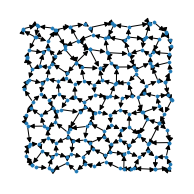

In [57]:
k='train'
print('{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Helper functions

In [58]:
def plot_losses(train_log, loaders, dataset_legend,figsize=[15,8]):
    if figsize is not None:
        plt.figure(figsize=figsize)
    training_epochs = np.arange(train_log['total_epochs'])
    for data_name in loaders:
        plt.plot(training_epochs, train_log[f'{data_name}_loss_tot'],lw=3,label=f'{dataset_legend[data_name]}')
    plt.legend();


def plot_velocity_predictions(vel_pred, vel_tgt, dataset_legend, figsize=[15,7]):
    var_type = 0
    var_name = '$\Delta{}x$'

    for data_name in vel_pred:
        minY, maxY  = torch.cat(vel_tgt[data_name],dim=0).min(), torch.cat(vel_tgt[data_name],dim=0).max()

        fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)    
        for k,ax in enumerate(axs):
            ax.plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
            ax.plot(torch.cat(vel_tgt[data_name], dim=0)[:,k],
                    torch.cat(vel_pred[data_name], dim=0)[:,k], 'o',ms=10,mfc='tomato',alpha=.25)
            ax.set_xlabel('True');
            ax.set_ylabel('Predicted')
            ax.set_title(f'{var_name}$_{k}$');
        plt.suptitle(f'{dataset_legend[data_name]}')
        plt.show()

#### Persistence Loss

In [47]:
print('Persistence:')
for k in datasets_dict:
    print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

Persistence:
	- Train (Sim:Non-zero): {'mae': 0.033784267, 'mse': 0.0021331417}
	- Sim(Non-zero): {'mae': 0.032130886, 'mse': 0.0019259002}
	- Sim(Zero): {'mae': 0.031817768, 'mse': 0.002040872}
	- Hara: {'mae': 0.020667922, 'mse': 0.0010290968}


In [48]:
len(datasets_dict['train'])

280

### Experiments

#### Plain MLP
> y=MLP(x) models (no graph), uses single node trends to predict trajectory

- Train on 5 movies from same sim param distrib.
    - Best MLP model for `window_size=5`: `net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[16,8,8,8,4],dropout_p=dropout_p)`
- Using 5+5 movies from two different sim param distrib-s
    - Needs more complex model.

In [105]:
from simgnn.models import Plain_MLP, PlainSquaredMLP

In [109]:
torch.manual_seed(0)

dropout_p = 0
num_epochs = 100
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')

# net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[512,256,128,64,32,16],dropout_p=dropout_p).to(device)
net = PlainSquaredMLP(in_features=window_size*2, out_features=2, hidden_dims=[512,512,256,128,64,32,32,16],dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
          'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
#            'val':    DataLoader(datasets_dict['val'], batch_size=bs),
#            'val2':    DataLoader(datasets_dict['val2'], batch_size=bs),
#            'early':    DataLoader(datasets_dict['early'], batch_size=bs),
#            'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
#            'late': DataLoader(datasets_dict['late'], batch_size=bs)}

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [110]:
print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss,
                               return_best=return_best)

20012022_082325_PlainSquaredMLP_dp0bs2w5
---
Training param-s: #epochs=100, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/99: train_loss_tot=0.002941; train_loss_y=0.002941; |val_loss_tot=0.001204; |val2_loss_tot=0.001307; |hara_loss_tot=0.001374; |4s
Epoch 1/99: train_loss_tot=0.001117; train_loss_y=0.001117; |val_loss_tot=0.0004651; |val2_loss_tot=0.0006212; |hara_loss_tot=0.002273; |8s
Epoch 2/99: train_loss_tot=0.0003749; train_loss_y=0.0003749; |val_loss_tot=0.0002783; |val2_loss_tot=0.0004405; |hara_loss_tot=0.003528; |11s
Epoch 3/99: train_loss_tot=0.0003206; train_loss_y=0.0003206; |val_loss_tot=0.0002626; |val2_loss_tot=0.0004049; |hara_loss_tot=0.003853; |14s
Epoch 4/99: train_loss_tot=0.0003131; train_loss_y=0.0003131; |val_loss_tot=0.0002677; |val2_loss_tot=0.0004213; |hara_loss_tot=0.004417; |18s
Epoch 5/99: train_loss_tot=0.0003057; train_loss_y=0.0003057; |val_loss_tot=0.0002593; |val2_loss_tot=0.0004003; |hara_loss_tot=0.004351; |

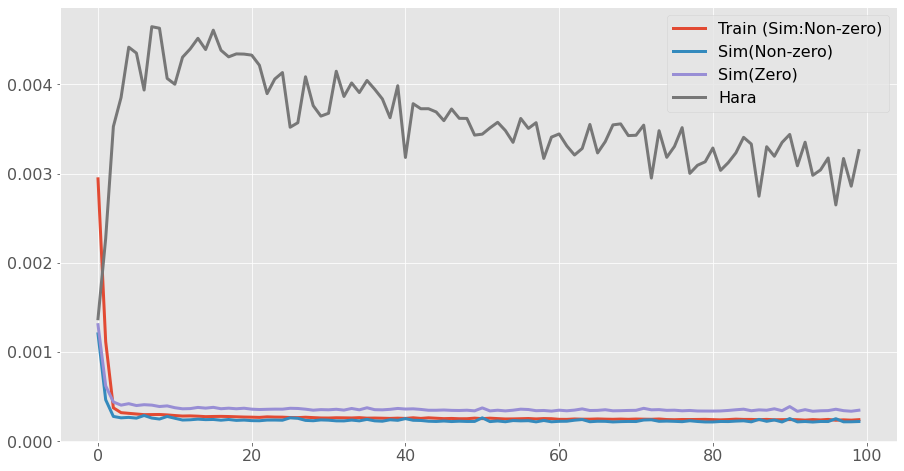

- train_loss_tot =0.0004630866885287831;
- train_loss_y =0.0004630866885287831;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.0004426695172690822;
- val_loss_y =0.0004426695172690822;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.0006955770078167911;
- val2_loss_y =0.0006955770078167911;
- val2_loss_T =0.0;
- val2_loss_P =0.0;
- hara_loss_tot =0.006515288400198693;
- hara_loss_y =0.006515288400198693;
- hara_loss_T =0.0;
- hara_loss_P =0.0;



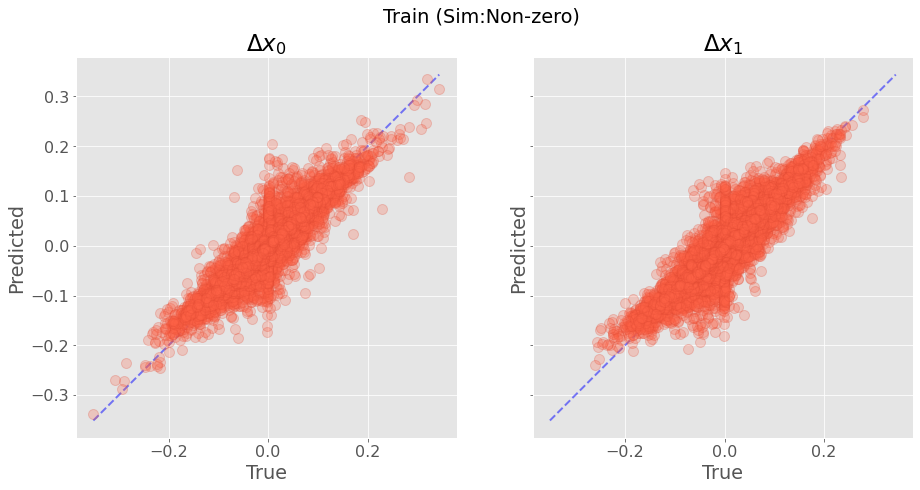

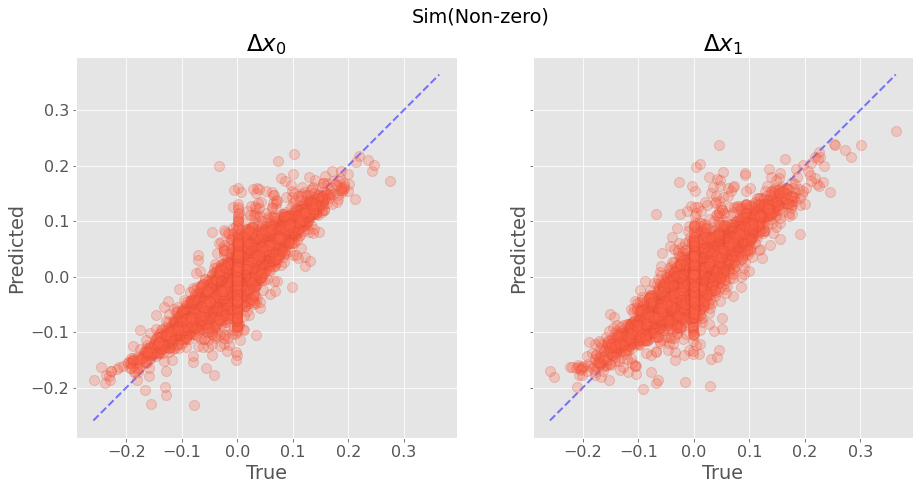

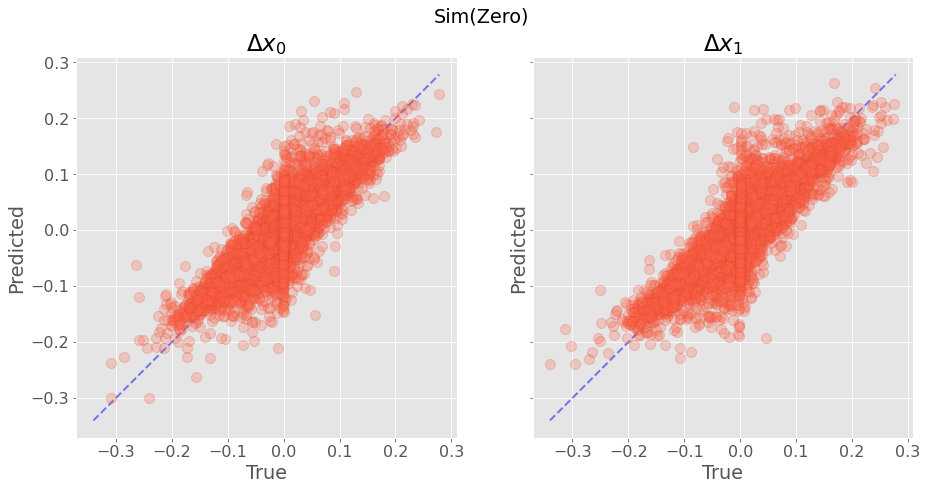

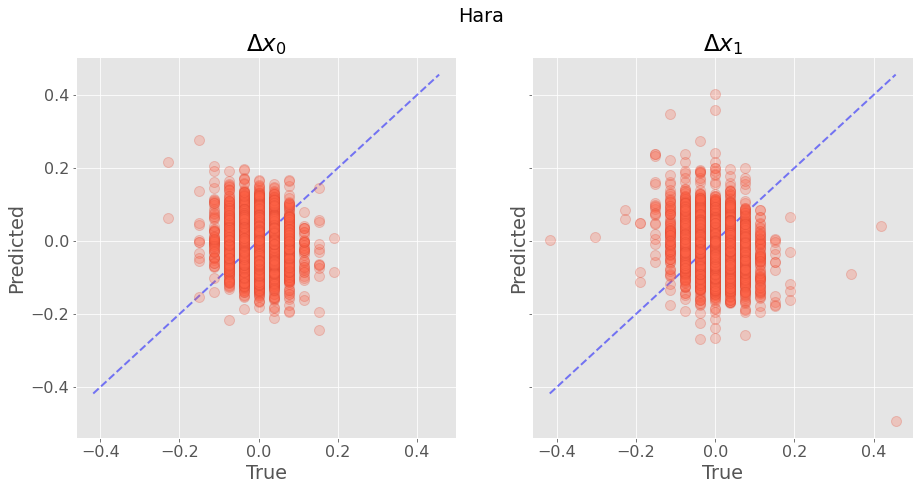

In [111]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [17]:
# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

---

#### Load Model and Check Performance

In [ ]:
dropout_p = 0.42
# net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[32,16,16,16,8,8],dropout_p=dropout_p).to(device)
# net_weights_dict = torch.load(path.join(save_dir, '31052021_064810_Plain_MLP_dp0.1bs32w5best_net.pkl'), map_location=device)

net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[64,32,16,16,16,16],dropout_p=dropout_p).to(device)
net_weights_dict = torch.load(path.join(save_dir, '29052021_190220_Plain_MLP_dp0.5bs32w5_net.pkl'), map_location=device)

net.load_state_dict(net_weights_dict)
net.eval();

In [ ]:
# predict(net, train1[0], loss_func=loss_func, use_force_loss = use_force_loss['train'], return_losses = False, device=device)

In [ ]:
from simgnn.train import predict, predict_batch
# plot losses
# plot_losses(train_log, loaders, dataset_legend); plt.show()
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))
plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [ ]:
# plt.figure(figsize=[35,10])
# ax1 = plt.subplot(1,4,1)
# ax1.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# ax1.hlines(0.0041163876,0,30)
# ax1.axis([0,30,0.00325,.0043]);
# ax1.legend();

# ax2 = plt.subplot(1,4,2,sharex=ax1,sharey=ax1)
# ax2.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=4,label='Early',alpha=.7)
# ax2.hlines(0.0042118663,0,30)
# ax2.legend();

# ax3 = plt.subplot(1,4,3,sharex=ax1,sharey=ax1)
# ax3.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=4,label='Middle',alpha=.7)
# ax3.hlines(0.00330922,0,30)
# ax3.legend();


# ax4 = plt.subplot(1,4,4,sharex=ax1)
# ax4.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=4,label='Late',alpha=.7)
# ax4.hlines(0.004734805,0,30)
# ax4.axis([0,30,0.004,.0048]);
# ax4.legend();

In [ ]:
# plt.figure(figsize=[15,8])
# plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
# plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# plt.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=3,label='Early',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=3,label='Middle',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=3,label='Late',alpha=.7)
# plt.legend();
# plt.axis([0,30,0,.009]);


---

#### Single Message Passing Step
> Single MP step, uses graph and relative node positions w.r.t. connected neighbouring nodes

- Single MP step w/ a very simple Update mlp. Update stage is equivalent to the node model (plain mlp) w/ an additional edge features as messages.

In [59]:
from simgnn.models import Single_MP_step, SingleMPStepSquared
#mlp, Message, AggregateUpdate, Aggregate

In [101]:
torch.manual_seed(0)

dropout_p = 0.2
weight_decay = 0
num_epochs = 30
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')
# Deep model msg_dim=320; msg_nlayers=4; upd_dim=514; upd_nlayers=3
msg_dim = 32
msg_nlayers = 4 # in+out+#hidden_layers
upd_dim = 128
upd_nlayers = 5# in(msg,x)+out(y)+#hidden_layers

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                     message_out_features=msg_dim, message_hidden_dims=[msg_dim for k in range(msg_nlayers-2)],
                     aggr='mean', update_hidden_dims=[upd_dim for k in range(upd_nlayers-2)], dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
# opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# opt = torch.optim.Adamax(net.parameters(), lr=lr)
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(opt, 100, gamma=0.1)

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val':    DataLoader(datasets_dict['val'], batch_size=bs),
           'val2':    DataLoader(datasets_dict['val2'], batch_size=bs),
           'early':    DataLoader(datasets_dict['early'], batch_size=bs),
           'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
           'late': DataLoader(datasets_dict['late'], batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [102]:
print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

20012022_081437_Single_MP_step_dp0.2bs2w5
---
Training param-s: #epochs=30, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=0.001513; train_loss_y=0.001513; |val_loss_tot=0.0004439; |val2_loss_tot=0.0006089; |early_loss_tot=8.808e-05; |mid_loss_tot=7.195e-05; |late_loss_tot=0.0001219; |3s
Epoch 1/29: train_loss_tot=0.0005882; train_loss_y=0.0005882; |val_loss_tot=0.000304; |val2_loss_tot=0.0004621; |early_loss_tot=0.0001008; |mid_loss_tot=7.165e-05; |late_loss_tot=0.0001433; |6s
Epoch 2/29: train_loss_tot=0.000484; train_loss_y=0.000484; |val_loss_tot=0.0002873; |val2_loss_tot=0.0004251; |early_loss_tot=0.0001029; |mid_loss_tot=6.881e-05; |late_loss_tot=0.000132; |9s
Epoch 3/29: train_loss_tot=0.0004384; train_loss_y=0.0004384; |val_loss_tot=0.0002656; |val2_loss_tot=0.0004015; |early_loss_tot=0.0001091; |mid_loss_tot=7.501e-05; |late_loss_tot=0.0001593; |11s
Epoch 4/29: train_loss_tot=0.0004194; train_loss_y=0.0004194; |val_loss

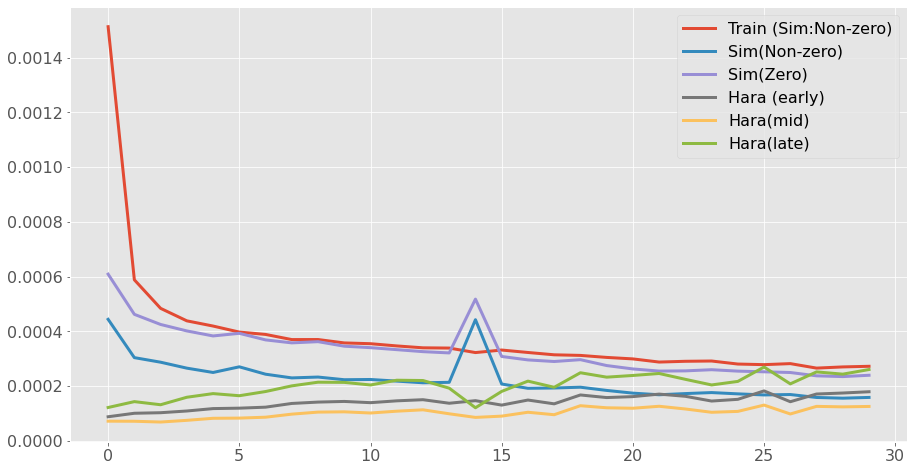

In [103]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

- train_loss_tot =0.00037225053407362974;
- train_loss_y =0.00037225053407362974;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00031738218468117135;
- val_loss_y =0.00031738218468117135;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00047927728908440367;
- val2_loss_y =0.00047927728908440367;
- val2_loss_T =0.0;
- val2_loss_P =0.0;
- early_loss_tot =0.00035890328084550255;
- early_loss_y =0.00035890328084550255;
- early_loss_T =0.0;
- early_loss_P =0.0;
- mid_loss_tot =0.0002514763977848181;
- mid_loss_y =0.0002514763977848181;
- mid_loss_T =0.0;
- mid_loss_P =0.0;
- late_loss_tot =0.0005211428954051092;
- late_loss_y =0.0005211428954051092;
- late_loss_T =0.0;
- late_loss_P =0.0;



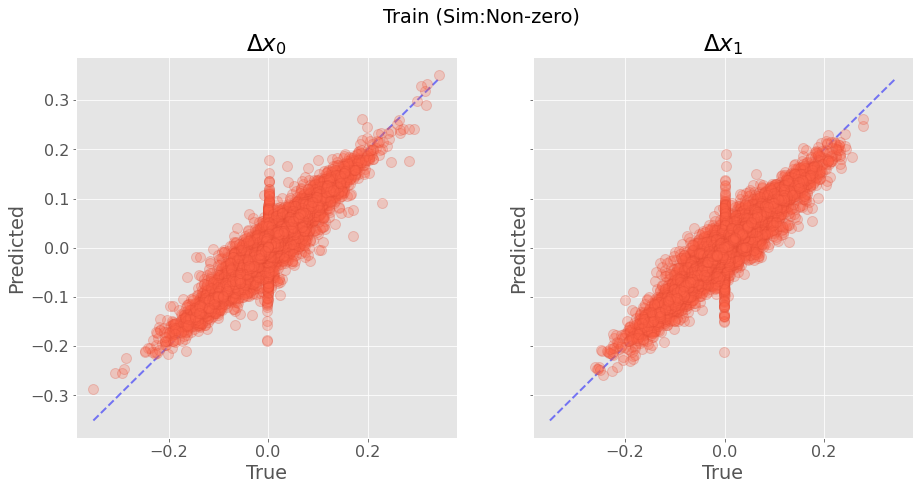

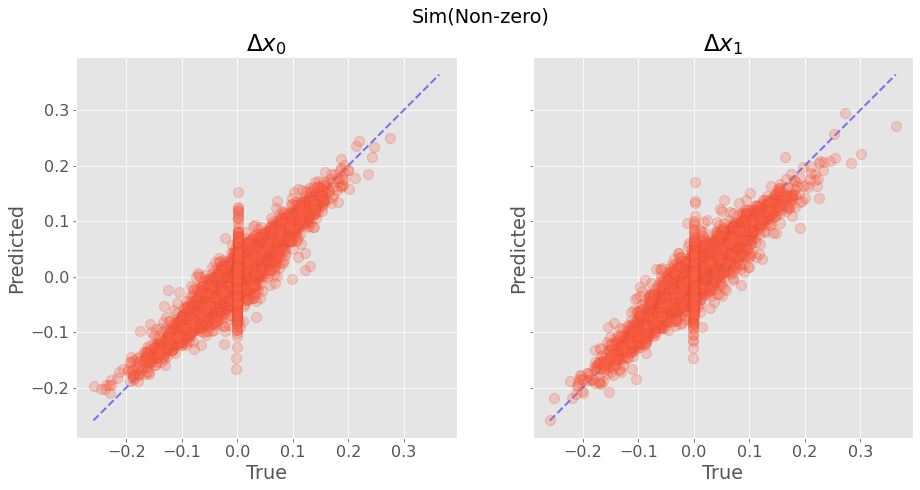

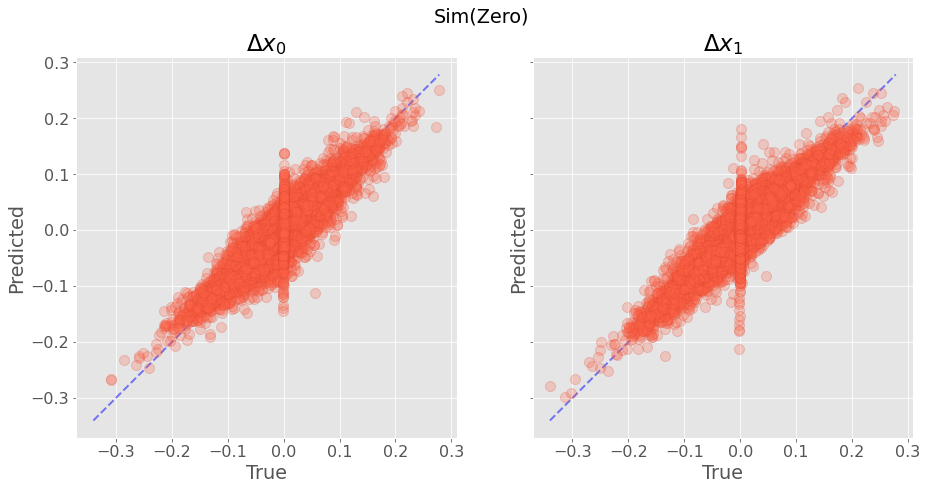

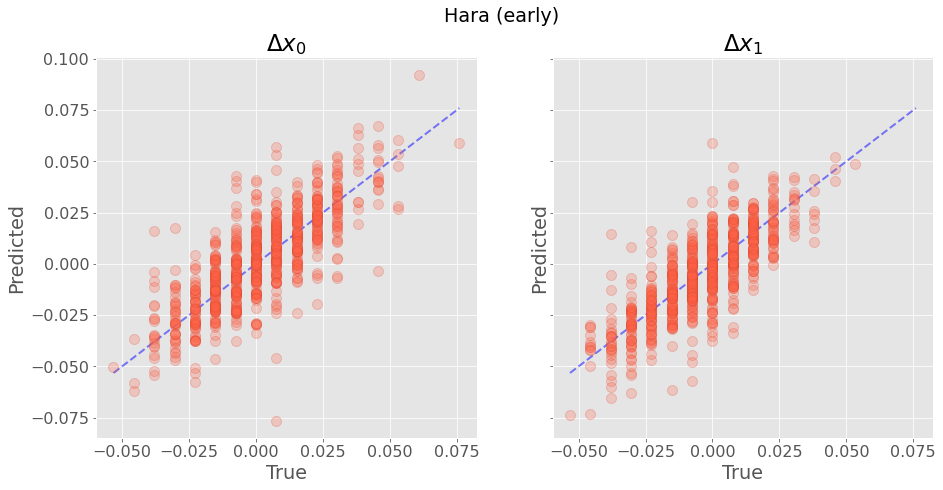

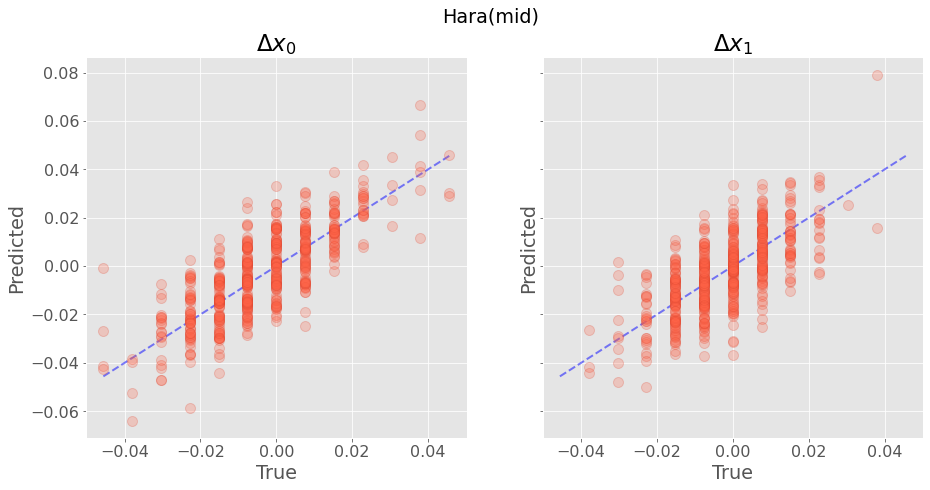

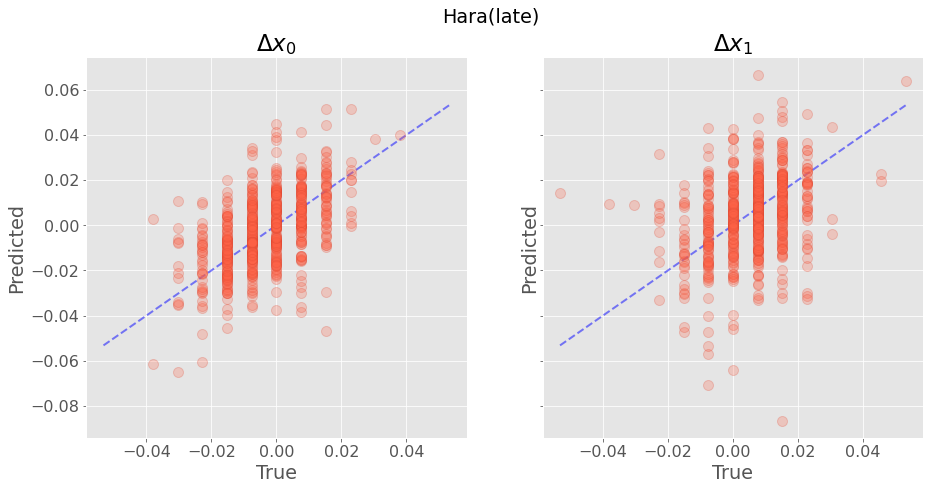

In [104]:
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k:False for k in loaders}, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [42]:
write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

Model weights saved in 
./simgnn_data/saved_models/05062021_193518_Single_MP_step_dp0.4bs2w5_net.pkl
